In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
# Logsumexp function
from scipy.misc import logsumexp
# gaussian pdf
from scipy.stats import multivariate_normal

In [89]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%precision %.5f
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30
plt.rcParams['axes.titlesize'] = 30
plt.rc('text', usetex=True)
plt.rc('font',**{'family':'serif','serif':['Palatino']})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Tools

In [3]:
from tools.graphics import as_si, make_grid, plot_data, plot_frontiere, plot_cov_ellipse
from tools.mixture import K_means, GM

# Constants

In [4]:
DATA_DIR = "data/"
COLS = ["red", "blue","green", "orange", "black", "cyan"]
MARKS = ["^","+","*","o","x","."]

## Reading data

In [5]:
D = {}
for t in ["data", "test"]:
    D[t] = pd.read_csv(DATA_DIR + "EMGaussian" + "." + t, sep = ' ', names = ["x1", "x2"])

In [14]:
len(D["test"])

500

## Previously found gaussiens

### Previous parameters found

In [43]:
previous_params = np.load("mixture_parameters.npy").item()
previous_params

{'mu': array([[-3.05990034, -3.53259873],
        [-2.03407708,  4.1728797 ],
        [ 3.9808156 ,  3.83153862],
        [ 3.79964793, -3.77776709]]),
 'sigma': array([[[  6.25185283,   6.0599484 ],
         [  6.0599484 ,   6.19158314]],
 
        [[  2.90573511,   0.2077826 ],
         [  0.2077826 ,   2.75669466]],
 
        [[  0.20861629,   0.27747176],
         [  0.27747176,  11.97735281]],
 
        [[  0.91297431,   0.05584533],
         [  0.05584533,   1.9066195 ]]])}

### Generate multivariate gaussien from those parameters

In [191]:
emission = np.array([multivariate_normal(previous_params["mu"][key], previous_params["sigma"][key])
           for key in range(previous_params["mu"].shape[0])])

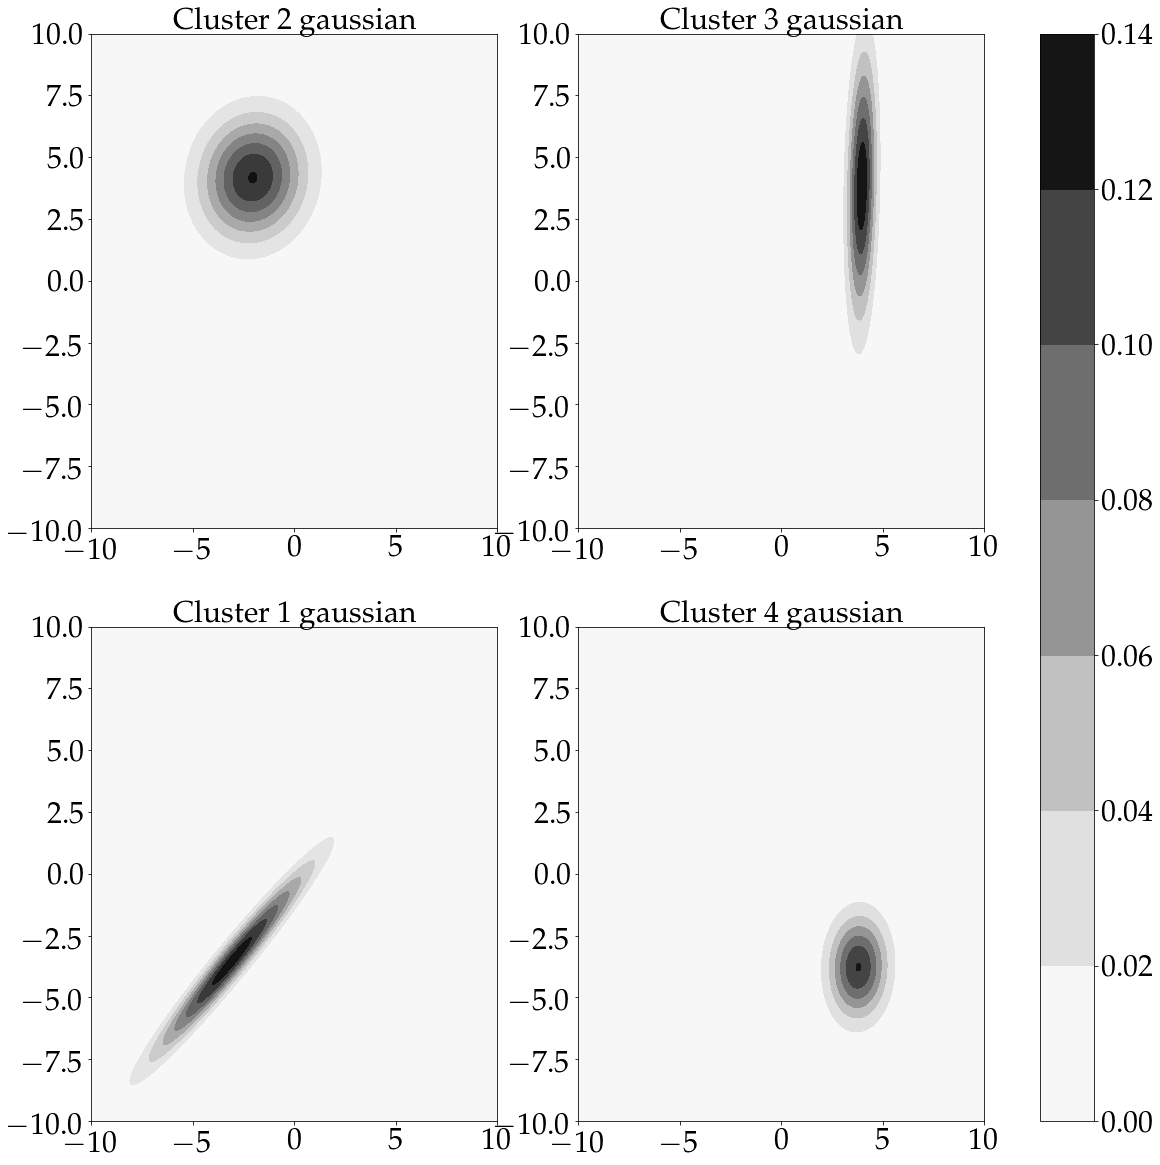

In [192]:
x, y = np.mgrid[-10:10:.01, -10:10:.01]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y
cmap = 'Greys'

f, ax = plt.subplots(2, 2, figsize = (20, 20));
im1 = ax[1][0].contourf(x, y, emission[0].pdf(pos), cmap = cmap);
ax[1][0].set_title("Cluster 1 gaussian");
ax[0][0].contourf(x, y, emission[1].pdf(pos), cmap = cmap);
ax[0][0].set_title("Cluster 2 gaussian");
ax[0][1].contourf(x, y, emission[2].pdf(pos), cmap = cmap);
ax[0][1].set_title("Cluster 3 gaussian");
im4 = ax[1][1].contourf(x, y, emission[3].pdf(pos), cmap = cmap);
ax[1][1].set_title("Cluster 4 gaussian");
plt.colorbar(im4, ax = ax);

# HMM - implementation

In [262]:
class HMM(object):
    """
    HMM handmade class
    """

    def __init__(self, u, nbr_states, emission, A = None, pi = None):
        """
        Parameters:
        -----------
        u:                   array-like, shape (T,d)
                             T observations of d dimension
        nbr_states:          positive integer
                             number of hidden states
        emission:            array of variables
                             emission probability distributions
        A:                   array
                             state transition matrix
        pi:                  array-like, shape(nbr_states,)
                             initial state distribution
        """
        self.u = u
        self.T = u.shape[0]
        self.d = u.shape[1]
        self.M = nbr_states
        self.O = emission
        self.A = A
        self.pi = pi
        if len(self.O) != self.M:
            raise ValueError("Number of states {} and number of emission {}"
            "distributions do not match.".format(self.M, len(self.O)))
        if A is not None:
            if A.shape[0] != A.shape[1] or not (np.round(A.sum(0), 3) == [1] * nbr_states).all():
                raise ValueError("A is not a valid transition matrix")
        if pi is not None:
            if len(pi) != nbr_states:
                raise ValueError("Number of states {} and length of distribution of initial states {}"
                                 "do not match".format(self.M, len(self.pi)))
        self.alphas = None
        self.betas = None
        return

    def _check_parameters(self):
        """
        Checking needed parameters for inference tasks
        """
        if self.A is None:
            raise ValueError("State transition matrix is empty")
        elif self.pi is None:
            raise ValueError("Initial state distribution is unknown")
        return

    def _alpha_recursion(self):
        """
        Alpha recursion
        """
        # Can't do inference if A or pi is missing
        self._check_parameters()
        alphas = np.zeros((self.M, self.T))
        # Initialization of alphas
        alphas[:, 0] = np.log(self.pi * np.array([self.O[i].pdf(self.u[0]) for i in range(self.M)]))
        # For the t_th observation
        for t in range(1, self.T):
            # Compute the path for the i_th state
            for i in range(self.M):
                alphas[i, t] = np.log(self.O[i].pdf(self.u[t])) + logsumexp(alphas[:, t - 1], b = A[:, i])
        self.alphas = alphas
        return

    def _beta_recursion(self):
        """
        Beta recursion
        """
        # Can't do inference if A or pi is missing
        self._check_parameters()
        betas = np.zeros((self.M, self.T))
        # Initialization of betas
        betas[:, self.T - 1] = [1] * self.M
        # For the t_th observation
        for t in range(self.T - 2, -1, -1):
            # Compute the path for the i_th state
            for i in range(self.M):
                betas[i, t] = logsumexp(betas[:, t + 1],
                                        b = A[i, :] * [self.O[q].pdf(self.u[t + 1]) for q in range(self.M)])
        self.betas = betas
        return
    def _filtering(self, t):
        """
        Inference task: filtering
        Find the distribution of the hidden state at t given the actual observations
        """
        # Compute alphas and betas if needed
        if self.alphas is None:
            self._alpha_recursion()
        elif self.betas is None:
            self._beta_recursion()
        return self.alphas[:, t] + self.betas[:, t] - logsumexp(self.alphas[-1, :])

In [220]:
i = 2
A[i, :] * [emission[q].pdf(x) for q in range(4)]

array([  8.53032998e-03,   5.16252454e-05,   6.69204855e-28,
         5.60068102e-09])

In [176]:
HMM(np.zeros((10, 1)), 5, {0: "test", 1: "test", 2: "test", 3: "test", 4: "test"})

We consider the following HMM model : the chain (q t ) has K = 4 possible states,
with an initial probability distribution π ∈ R 4 and a probability transition matrix
A ∈ R 4×4 , and conditionally on the current states we have observations obtained from
Gaussian emission probabilities u t |q t = i ∼ N (μ i , Σ i ).

## 1. $\alpha$ and $\beta$ recursion
Implement the recursions α et β seen in class (and that can be found in the
polycopié as well) to compute p(q t |u 1 , . . . , u T ) and p(q t , q t+1 |u 1 , . . . , u T ).

In [9]:
logsumexp([10, 20])

20.00005

In [244]:
x = np.array([-4.7764, -5.0763])
np.log(pi * np.array([emission[i].pdf(x) for i in range(4)]))

array([  -3.82555324,  -20.50175502, -187.79325629,  -43.93744699])

In [206]:
np.array([emission[i].pdf(x) for i in range(4)])

array([  5.11819799e-02,   3.09751472e-04,   1.33840971e-27,
         3.36040861e-08])

In [203]:
x = [-1, -1]
alphas = np.zeros((4, 10))
alphas[:, 0] = np.array([emission[i].pdf(x) for i in range(4)])

## 2. $p(q_t \mid u_1, \dots, u_T)$ using $\alpha$ and $\beta$ recursion
Using the same parameters for the means and covariance matrix of the 4 Gaus-
sians as the ones obtained in the previous homework, taking a uniform initial
probability distribution $\pi$, and setting A to be the matrix with diagonal coef-
ficients $A_{ii} = \frac{1}{2}$ and off-diagonal coefficients $A_{ij} = \frac{1}{6} \forall (i, j) \in [1, \dots , 4]^2$ , compute $\alpha_t$ and $\beta_t$ for all t on the test data (_EMGaussienne.test_ file) and
compute $p(q_t \mid u_1, \dots, u_T)$. Finally, represent $p(q_t \mid u_1, \dots, u_T)$ for each of the 4
states as a function of time for the 100 first datapoints in the file. Note that only the 100 first points should be plotted by that filtering should be done with all the data (i.e. T = 500). This will be the same for the subsequent questions.

In [227]:
pi = [1/4] * 4
pi

[0.25000, 0.25000, 0.25000, 0.25000]

In [164]:
A = np.zeros((4,4)) + 1/6
np.fill_diagonal(A, 1/2)
A

array([[ 0.5       ,  0.16666667,  0.16666667,  0.16666667],
       [ 0.16666667,  0.5       ,  0.16666667,  0.16666667],
       [ 0.16666667,  0.16666667,  0.5       ,  0.16666667],
       [ 0.16666667,  0.16666667,  0.16666667,  0.5       ]])

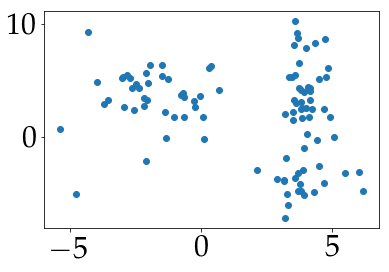

In [234]:
# First 100 points of the test dataset
first_100 = D["test"].as_matrix()[:100]
plt.scatter(first_100[:, 0], first_100[:, 1]);

In [266]:
hmm = HMM(first_100, 4, emission, A = A, pi = pi)
hmm._alpha_recursion()
hmm._beta_recursion()
alpha = hmm.alphas
betas = hmm.betas
filtering = hmm._filtering(0)
filtering

array([-477.62801637, -495.40172116, -662.69405427, -518.83824496])

In [256]:
np.exp(alpha[:, -1]).sum()

0.00000